In [107]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import heapq as hq

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import truncnorm, norm

from tqdm import tqdm_notebook as tqdm

In [4]:
def greedy_rej_sample(q, p):
    # Harsha greedy rejection sampler
    
    pass

In [5]:
def trunc_gumbel(seed, mean, b):
    # Scale fixed to 1
    
    # To sample from Gumbel(mu, max):
    # u ~ U([0, 1])
    # x = mu - log(exp(mu - b) - log(u))
    
    np.random.seed(seed)
    
    u = np.random.uniform()
    g = mean - np.log(np.exp(mean - b) - np.log(u))
    
    return g

In [161]:
def coded_a_star_sample(trunc_sample, 
                        log_diff, 
                        range_cdf,
                        range_bound, 
                        seed, 
                        eps=1e-5):
    
    # Define stuff
    lower_bound = -np.inf
    samp = None
    samp_path = None
    
    idx = "0"
    
    # We will store all Gumbel samples here
    gs = {}
    
    # argmaxes go here
    xs = {}
    
    # bounds go here
    bounds = {}
    
    # upper bounds go here
    upper_bounds = {}
    
    search_heap = []
    
    # Convert the search path to a number
    num_idx = int(idx, 2) + seed
    
    # Sample g ~ Gumbel(0), the maximum of the Gumbel process
    g = trunc_gumbel(num_idx, 0, np.inf)
    
    # Sample x, the argmax of the Gumbel process
    start_bound = (-np.inf, np.inf)
    
    x = trunc_sample(num_idx, start_bound)
    
    # Get the bound on the whole of |R
    _, m = range_bound(start_bound)
    
    # Record these
    gs[idx] = g
    xs[idx] = x
    bounds[idx] = start_bound
    upper_bounds[idx] = m
    
    # Push with priority g + m the current index to investigate.
    # Note: python's implementation of the heap is a min-heap, hence we actually push 
    # with priority -(g + m)
    hq.heappush(search_heap, (-(g + m), idx))
    
    # Iterate while the heap is not empty and while the lower bound is smaller than the
    # next best upper bound
    while len(search_heap) > 0 and lower_bound < -search_heap[0][0]:
        
        # Get the sample with current highest upper bound
        _, p = hq.heappop(search_heap)
        
        # Calculate the lower bound
        lb_p = gs[p] + log_diff(xs[p])
        
        # If we have a higher lower bound, we set our candidate 
        # lower bound and sample to the current ones
        if lower_bound < lb_p:
            
            lower_bound = lb_p
            samp = xs[p]
            samp_path = p
    
        # Partition the current bound: split at X_p
        L, R = (bounds[p][0], xs[p]), (xs[p], bounds[p][1])
        
        for partition, direction in [(L, "0"), (R, "1")]:
            # Decide if we should investigate the partition based on its size.
            if partition[1] - partition[0] >= eps:
                
                # The index is the current search path plus the direction we are taking 
                idx = p + direction
                
                # Convert search path to number
                num_idx = int(idx, 2) + seed
                
                # Sample stuff
                g = trunc_gumbel(num_idx, np.log(range_cdf(partition)), gs[p])
                x = trunc_sample(num_idx, partition)
                
                gs[idx] = g
                xs[idx] = x
                bounds[idx] = partition
                
                if lower_bound < g + upper_bounds[p]:
                    
                    # Get new upper bound
                    _, m = range_bound(partition)
                    upper_bounds[idx] = m
                    
                    # If the new upper bound is worth investigating, push it
                    if lower_bound < g + m:
                        hq.heappush(search_heap, (-(g + m), idx))
                        
    return lower_bound, samp, samp_path

In [162]:
def trunc_norm_sample(seed, bounds, loc, scale): 
    np.random.seed(seed)
    return truncnorm.ppf(np.random.uniform(), bounds[0], bounds[1], loc=loc, scale=scale)


def normal_log_diff(x, p_loc, p_scale, q_loc, q_scale):
    # logQ(x) - logP(x)
    return norm.logpdf(x, loc=q_loc, scale=q_scale) - norm.logpdf(x, loc=p_loc, scale=p_scale)


def normal_range_cdf(bounds, loc, scale):
    # P(a < X < b) = P(X < b) - P(a < X)
    return norm.cdf(bounds[1], loc, scale) - norm.cdf(bounds[0], loc, scale)


def normal_range_bound(bounds, p_loc, p_scale, q_loc, q_scale):
    # Range bound on logQ(x) - logP(x)
    
    if p_scale <= q_scale:
        raise Exception("The log difference is undbounded!")

    max_point = (q_scale**2 * p_loc - p_scale**2 * q_loc) / (q_scale**2 - p_scale**2)
    
    if bounds[0] > max_point:
        max_point = bounds[0]
    
    elif bounds[1] < max_point:
        max_point = bounds[1]
        
    return max_point, normal_log_diff(max_point, p_loc, p_scale, q_loc, q_scale)

def normal_kl(p_loc, p_scale, q_loc, q_scale):
    
    return np.log(p_scale) - np.log(q_scale) + (q_scale**2 + (q_loc - p_loc)**2) / (2 * p_scale**2) - 0.5

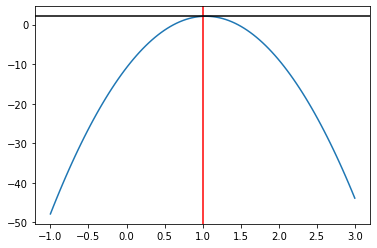

In [177]:
p_loc = 0.
q_loc = 1.

p_scale = 1.
q_scale = 0.2

xs = np.linspace(-1, 3, 100)

d = normal_log_diff(xs, p_loc, p_scale, q_loc, q_scale)

argmax, maxline = normal_range_bound((0, 1), p_loc, p_scale, q_loc, q_scale)

plt.plot(xs, d)
plt.axvline(argmax, color='r')
plt.axhline(maxline, color='k')

In [175]:
samps = []

samp_paths = []

for i in tqdm(range(1000)):

    lb, samp, samp_path = coded_a_star_sample(
        trunc_sample = lambda seed, bounds: trunc_norm_sample(seed, bounds, p_loc, p_scale), 
        log_diff = lambda x: normal_log_diff(x, p_loc, p_scale, q_loc, q_scale), 
        range_cdf = lambda bounds: normal_range_cdf(bounds, p_loc, p_scale),
        range_bound = lambda bounds: normal_range_bound(bounds, p_loc, p_scale, q_loc, q_scale), 
        seed = i)
    
    samps.append(samp)
    samp_paths.append(samp_path)

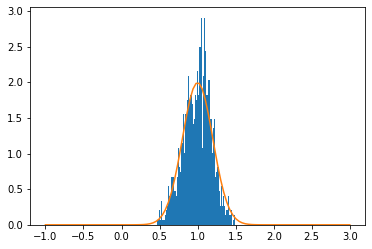

In [178]:
plt.hist(samps, bins=70, density=True)
plt.plot(xs, norm.pdf(xs, loc=q_loc, scale=q_scale))
plt.show()

In [179]:
expected_length = normal_kl(p_loc, p_scale, q_loc, q_scale)
empirical_length = sum(map(len, samp_paths)) / len(samp_paths)

print("Expected Length: {:.3f}".format(expected_length))
print("Empirical Length: {:.3f}".format(empirical_length))

Expected Length: 1.629
Empirical Length: 3.662


In [191]:
np.random.seed(42)

loc_range = [-3, 3]
scale_range = [0.2, 1]

num_dims = 4

q_locs = np.random.uniform(size=(num_dims,), low=loc_range[0], high=loc_range[1])
q_scales = np.random.uniform(size=(num_dims,), low=scale_range[0], high=scale_range[1])

kls = np.array([normal_kl(0., 1., q_loc, q_scale) for q_loc, q_scale in zip(q_locs, q_scales)])

softmax_dist = np.exp(kls) / np.sum(np.exp(kls))

In [197]:
t = np.random.choice(range(4), size=100, p=softmax_dist)